# I. Probability

From the continuous stream of data, extract the periods of interest to train a classifier aiming to predict an incoming movement from the user.
These periods of interest will be used to extract features and then to calculate the probability of predecting an incoming movement on a specific period of interest (around the movement onset).

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from matplotlib.pyplot import figure
from matplotlib.lines import Line2D
from scipy.stats import wilcoxon
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold, cross_val_predict
from sklearn.metrics import roc_curve, auc, roc_auc_score, plot_roc_curve, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay, classification_report, RocCurveDisplay
from sklearn.model_selection import StratifiedKFold
from scipy.stats import zscore

## 1. Parameters and functions definition

### Parameters

Define in the parameters the start and the end of the each period of interest. The start and end are defined with respect to the event chosen later on (movement onset or other).

- Idle for each modality which will be class 0
- Incoming period for all modality which will be class 1
- Period on which we want to calculate the probability of prediction

In [2]:
fs         = 250
path       = 'C:/Users/willy/OneDrive/Documents/GitHub/Intent-to-interact/data/'
parameters = {'idle_eeg_start'  :  1.5, 'idle_eeg_end'  : 2.5, 
              'idle_emg_start'  :  1.5, 'idle_emg_end'  : 2.5,
              'idle_gaze_start' :  1.5, 'idle_gaze_end' : 2.5,
              'intent_start'    : -1, 'intent_end'    : 0, 
              'interest_start'  : -2, 'interest_end'  : 1}
train_size = 100

### Functions leading to probability calculation

<font size="7" color='red'>    <b>Read/load data</b>
    
Data are just pre-processed. EMG, EEG and Eye-tracking are under the form of a continuous stream recorded all along the experiment. 
It takes time to read all the data so we'll create a function to load everything once then save it under npy array.

In [4]:
def read_and_save(ID):
    
    '''
    Just run once once, read and save the data under .npy form.
    '''
    
    ID             = str(ID)
    
    movement_onset = pd.read_csv( path + ID + '/\motion_onset_event_latencies.csv', header = None)
    movement_onset = movement_onset.values[0]
    
    idle_onset     = pd.read_csv( path + ID + '/\idle_event_latencies.csv', header = None)
    idle_onset     = idle_onset.values[0]

    
    eeg_all        = pd.read_csv(path + ID + '/\eeg.csv', header = None)
    best_chan      = pd.read_csv(path + ID + '/\chans_rp-win_-1-0.csv', header=None)
    eeg = []
    for i in best_chan.iloc[1:,0].astype(int)-1:  
        eeg.append(eeg_all.iloc[i,:])
    eeg = np.asarray(eeg)
    
    noisy_idle     = pd.read_csv(path + ID + '/noisy_epochs_idle_rp-win_-1-0.csv', header = None)
    noisy_intent   = pd.read_csv(path + ID + '/noisy_epochs_rp_rp-win_-1-0.csv', header = None)
        
    emg            = pd.read_csv(path + ID + '/\emg.csv', header = None)
    emg.iloc[1,:]  = emg.iloc[1,:] - np.mean(emg.iloc[1, :])
    emg.iloc[0,:]  = emg.iloc[0,:] - np.mean(emg.iloc[0, :])
        
    velocity       = pd.read_csv(path + ID + '/\motion.csv', header = None)
    
    np.save(path + ID + '/NPYmovement', movement_onset)
    np.save(path + ID + '/NPYidle', idle_onset)
    np.save(path + ID + '/NPYeeg', eeg)
    np.save(path + ID + '/NPYnoisy_idle', noisy_idle)
    np.save(path + ID + '/NPYnoisy_intent', noisy_intent)
    np.save(path + ID + '/NPYemg', emg)
    np.save(path + ID + '/NPYvelocity', velocity)


In [5]:
def load(ID):
    
    '''
    Load the .npy files and create a data dictionnary.
    '''
    
    ID = str(ID)
    
    movement_onset = np.load(path + ID + '//NPYmovement.npy')
    idle_onset     = np.load(path + ID + '/NPYidle.npy')
    eeg            = np.load(path + ID + '//NPYeeg.npy')
    emg            = np.load(path + ID + '//NPYemg.npy')
    velocity       = np.load(path + ID + '//NPYvelocity.npy') 
    noisy_idle     = np.load(path + ID + '//NPYnoisy_idle.npy', allow_pickle=True)
    noisy_intent   = np.load(path + ID + '//NPYnoisy_intent.npy', allow_pickle=True)
    
    data = {'movement_onset' : movement_onset, 'idle_onset' : idle_onset,
            'eeg' : eeg, 'emg' : emg, 'velocity' : velocity, 'gaze' : [],
            'noisy_idle' : noisy_idle, 'noisy_intent' : noisy_intent}
    
    return data

<font size="7" color='red'>    <b>Time Frame of interest</b>
    
__full data dictionnary__  &#8594;  __dictionnary with time frames of interest__
    
To reduce the processing time, we extract the different timeframes of interest from the continuous streams of data. 

The following function is applying this process to extract the class 0 (idle) and 1 (intent) of our future classifier as well as the period on which we'll want to test this classifier (interest).


In [6]:
def area_of_interest(signal, events, start, end):
    
    '''
    This function exctracts the timeframe of interest from a continuous stream.
    It requires: the continuous stream, the targeted event for the extraction and 
    the time in seconds before and after this event to define the timeframe.
    '''
    
    samples_before = fs *   start
    samples_after  = fs *   end
    area           = np.zeros((len(events), -(int(samples_before) - int(samples_after)), signal.shape[0]))
    
    for k in range(len(events)):
        
        for j in range(signal.shape[0]):
            
            area[k, 0:-(int(samples_before)-int(samples_after)), j] = signal[j, events[k] + int(samples_before) : 
                                                                      events[k] + int(samples_after)]
            
    return area

In [7]:
def areas(data):
    
    '''
    This uses the function defined above to extract the idle, the intent and the interest of each modality.
    Each area use the data dictionnary as input + the parameters defined in the beginning.
    
    !! We take 1s earlier of the timeframe of interest because the feature extraction on sliding window will reduce 
    the array size by 249 samples (if we want 3s of features array we need 4s of data). !!
    '''
    
    areas                      = {'idle_eeg': [], 'idle_emg': [],
                                  'intent_eeg': [], 'intent_emg': [],
                                  'interest_eeg': [], 'interest_emg': [], 'interest_velocity': []}
    
    areas['idle_eeg']          = area_of_interest(data['eeg'],  data['idle_onset'], 
                                              parameters['idle_eeg_start'], parameters['idle_eeg_end'])
    areas['idle_emg']          = area_of_interest(data['emg'],  data['idle_onset'],
                                              parameters['idle_emg_start'], parameters['idle_emg_end'])
    
    areas['intent_eeg']        = area_of_interest(data['eeg'],  data['movement_onset'], 
                                              parameters['intent_start'], parameters['intent_end'])
    areas['intent_emg']        = area_of_interest(data['emg'],  data['movement_onset'], 
                                              parameters['intent_start'], parameters['intent_end'])
    
    areas['interest_eeg']      = area_of_interest(data['eeg'],  data['movement_onset'], 
                                              parameters['interest_start']-1, parameters['interest_end'])
    areas['interest_emg']      = area_of_interest(data['emg'],  data['movement_onset'], 
                                              parameters['interest_start']-1, parameters['interest_end'])
    areas['interest_velocity'] = area_of_interest(data['velocity'], data['movement_onset'], 
                                              parameters['interest_start'], parameters['interest_end'])
    
    return areas

<font size="7" color='red'>    <b>Feature extraction</b>

__dictionnary with time frames of interest__  &#8594;   __features__   
    
Each modality has its specific processing and feature extraction, we define functions for each of them.
Below time-domain features for the EMG data. The EEG data will be processed calculating the window means and the gaze velocity will be computed for the eye-tracking data.

__EMG__ : - Feature definition - Feature extraction

__EEG__ : - Noisy idle and intent time frames removal - Feature extraction - Baseline correction

__Eye__ : - Feature extraction

In [8]:
'''
Define the functions for the features extraction on the EMG data.
We have in order: Root mean square, minimum, maximum, mean absolute value, variance, waveform length, zero crossing
slope sign change.
'''

def rms(values):
    return np.sqrt(sum(values**2)/len(values))

def mini(values):
    return np.min(values)

def maxi(values):
    return np.max(values)

def mav(values):
    return np.mean(abs(values))

def var(values):
    return np.var(values)

def waveform(values):
    return sum(abs(np.diff(values)))

def zc(values):
    z = 0
    for i in range(len(values)-1):
        if values[i] > 0 and values[i+1] < 0 and abs(values[i+1] - values[i]) > 0.001:
            z += 1
        elif values[i] < 0 and values[i+1] > 0 and abs(values[i+1] - values[i]) > 0.001:
            z += 1
        else:
            z += 0
    return z
    
def ssc(values):
    s = 0
    for i in range(len(values)-2):
        if values[i] > values[i+1] and values[i+1] > values[i+2] and abs(values[i+1] - values[i]) > 0.001 and abs(values[i+2] - values[i+1]) > 0.001:
            s += 1
        elif values[i] < values[i+1] and values[i+1] < values[i+2] and abs(values[i+1] - values[i]) > 0.001 and abs(values[i+2] - values[i+1]) > 0.001:
            s += 1
        else:
            s += 0
    return s

feat_list  = [rms, mini, maxi, mav, var, waveform, zc, ssc]
nfeat_list = ['rms', 'mini', 'maxi', 'mav', 'var', 'waveform', 'zc', 'ssc']

In [9]:
def emg_feature_extraction(area):
    
    '''
    Extract the EMG features on the areas of interest.
    Features are extracted once per second (1s = 250 samples) so once per idle and intent period.
    On the interest period, the features are extracted once, then the 250 samples window is slided by 1 sample 
    and the extraction starts again until the end.
    
    Dimensions of areas are (n_trials) * (samples) * (n_channels)
    
    It results in a matrix of dimensions (n_trials) * (features * n_channels) for idle and intent timeframes.
    or (n_trials) * (features * n_channels) * (n_windows) for the timeframe of interest.
    '''
    
    sld_size = 1
    
    if area.shape[1] == 250 or area.shape[1] == 50:                # For idle, intent period and accuracy on shorter timeframes.
        features = np.zeros((area.shape[0], area.shape[2] * len(feat_list)))
        for k in range(area.shape[0]):
            for j in range(area.shape[2]):
                for i in range(len(feat_list)):
                    
                    features[k, i + (len(feat_list)*j)] = np.apply_along_axis(feat_list[i], 0, area[k, :, j])
#        scaler = StandardScaler()
#        scaled_features = scaler.fit_transform(features) 
    
    else:
        features = np.zeros((area.shape[0], area.shape[2] * len(feat_list), (area.shape[1]//sld_size) - fs + sld_size))                  
        for l in range(features.shape[2]):
            for k in range(area.shape[0]):
                for j in range(area.shape[2]):
                    for i in range(len(feat_list)):
                            
                        features[k, i + (len(feat_list)*j), l] = np.apply_along_axis(feat_list[i], 0, 
                                                                 area[k, (sld_size*l):fs+(sld_size*l), j])
#        for s in range(features.shape[2]):
#            scaled_features = np.zeros((features.shape))
#            scaler = StandardScaler()
#            scaled_features[:, :, s] = scaler.fit_transform(features[:, :, s]) 
    
    return features

Before the feature extraction, we remove the __EEG__ idle and preparation period which were marked as too noisy during the pre-processing.

In [10]:
def eeg_filtering(data, area):
    
    '''
    Use the noisy idle and noisy intent to remove them from the extracted trials.
    
    -1 to all trial indices to match the trial count to python count.
    '''
   
    area['idle_eeg']   = np.delete(area['idle_eeg'], data['noisy_idle'][1:].astype(int)-1, axis=0)
    area['intent_eeg'] = np.delete(area['intent_eeg'], data['noisy_intent'][1:].astype(int)-1, axis=0)
        
    return area['idle_eeg'], area['intent_eeg']

In [11]:
def eeg_feature_extraction(area):
    
    '''
    Extract the mean on the eeg data as a feature.
    The mean is extracted 10 times per window per channel.
    Extract per second then slide the window per 1 sample for the area of interest.
    
    Dimensions of areas are (n_trials) * (samples) * (n_channels)
    
    It results in a matrix of dimensions (n_trials) * (features * n_channels) for idle and intent timeframes.
    or (n_trials) * (features * n_channels) * (n_windows) for the timeframe of interest.
    '''
    
    sld_size  = 1
    feat_size = 25
    
    if area.shape[1] == 250:                # For idle and intent period.
        features = np.zeros((area.shape[0], (fs//feat_size) * area.shape[2]))
        for k in range(area.shape[0]):
            for j in range(area.shape[2]):
                for i in range(fs//feat_size):
                    
                    features[k, i+(fs//feat_size) * j] = np.mean(area[k, (feat_size*i) : (feat_size)+(feat_size)*i, j])
                    
    elif area.shape[1] == 50:               # For accuracy on shorter timeframes.
        features = np.zeros((area.shape[0], (50//feat_size) * area.shape[2]))
        for k in range(area.shape[0]):
            for j in range(area.shape[2]):
                for i in range(50//feat_size):
                    
                    features[k, i+(50//feat_size) * j] = np.mean(area[k, (feat_size*i) : (feat_size)+(feat_size)*i, j])
                    
    else:                                   # For interest period.
        features = np.zeros((area.shape[0], (fs//feat_size) * area.shape[2], (area.shape[1]//sld_size) - fs + sld_size))
        for k in range(area.shape[0]):
            for l in range(features.shape[2]):
                for j in range(area.shape[2]):
                    for i in range(fs//feat_size):
                        
                        features[k, i+(fs//feat_size) * j, l] = np.mean(area[k, (feat_size*i)+(sld_size*l): \
                                                                               (feat_size)+(feat_size)*i+(sld_size*l), j])
    return features                    

The __EEG__ signal slowly shifts along the experiment, thus we proceed to a baseline correction to standardize the features between the early and late trials.

In [12]:
def baseline_correction(area, features):
    
    '''
    Substract to each window of the first value of the array.
    '''
    
    features_cor = np.zeros((features.shape))
    
    for k in range(features.shape[0]):
        
        if features.ndim == 2 and features.shape[1] == 200: # For idle and intent period.
        
            for j in range(area.shape[2]):
            
                features_cor[k, (10*j):10+(10*j)] = features[k, (10*j):10+(10*j)] - area[k, 0, j]
                
        elif features.ndim == 2 and features.shape[1] == 40: # For accuracy on shorter timeframes.
        
            for j in range(area.shape[2]):
            
                features_cor[k, (2*j):2+(2*j)] = features[k, (2*j):2+(2*j)] - area[k, 0, j]
        
        else:                                                    # For interest timeframe.
            
            for j in range(area.shape[2]):
                for i in range(features.shape[2]):
            
                    features_cor[k, (10*j):10+(10*j), i] = features[k, (10*j):10+(10*j), i] - area[k, i, j]
            
    return features_cor

In [13]:
def eye_feature_extraction(area):
    
    '''
    Use the gaze velocity as a feature.
    '''
    sld_size  = 1
    
    if area.shape[1] == 250 or area.shape[1] == 50: # For idle and intent period.
        features = np.zeros((area.shape[0], area.shape[1]))
        
        features = area[:, :, 0]
        
    else:
        features = np.zeros((area.shape[0], fs, (area.shape[1]//sld_size) - fs + sld_size))
        
        for l in range(features.shape[2]):          # For interest timeframe.
            features[:, :, l] = area[:, (sld_size*l):fs+(sld_size*l), 0]
    
    return features

<font size="7" color='red'>    <b>Classification</b>

Use the features to train a LDA classifier to predict in there is a movement preparation or not.

In [14]:
def classification(ID, features_idle, features_intention):
    
    '''
    All the features from all the modalities are going through the same classifier.
    
    Adjust train size in the parameter if we want to only use a part of them and the other part to calculate the probability.
    
    The function return the accuracy and the standart deviation output from a 10 fold cross-validation.
    
    Classification parameters are saved in order to use them to compute the classification metrics in another script.
    '''
    
    features_idle      = features_idle[:(len(features_idle)*train_size)//100, :]
    features_intention = features_intention[:(len(features_intention)*train_size)//100, :]
    
    class_0 = pd.concat([pd.DataFrame(features_idle), pd.DataFrame(np.zeros((len(features_idle))))], 
                        axis=1, keys={'features', 'class'})
    class_1 = pd.concat([pd.DataFrame(features_intention), pd.DataFrame(np.ones((len(features_intention))))], 
                        axis=1, keys={'features', 'class'})
    
    X       = pd.concat([class_0.iloc[:,:-1], class_1.iloc[:,:-1]], axis=0)
    y       = pd.concat([class_0.iloc[:,-1], class_1.iloc[:,-1]], axis=0)
    
    clf     = LDA(solver='lsqr', shrinkage='auto')
    clf.fit(X.values, y.values)
    
    kfolds  = KFold(n_splits=10, random_state=1, shuffle=True)
    
    pred_y  = cross_val_predict(clf, X.values, y.values, cv=kfolds)
    
    results = cross_val_score(clf, X.values, y.values, cv=kfolds)
    score   = np.mean(results)
    std     = np.std(results)
    
    ID      = str(ID)
    
    if features_idle.shape[1] == 200:
        np.save(path + ID + '/Xeeg', X)
        np.save(path + ID + '/yeeg', y)
        pickle.dump(clf, open(path + ID + '/Clfeeg', 'wb'))
        np.save(path + ID + '/pred_yeeg', pred_y)
        print('EEG Accuracy is ' + str(score))
        print('EEG Standard deviation is ' + str(std))
        
    elif features_idle.shape[1] > 200:
        np.save(path + ID + '/Xeeg_emg', X)
        np.save(path + ID + '/yeeg_emg', y)
        pickle.dump(clf, open(path + ID + '/Clfeeg_emg', 'wb'))
        np.save(path + ID + '/pred_yeeg_emg', pred_y)
        print('EEG-EMG Accuracy is ' + str(score))
        print('EEG-EMG Standard deviation is ' + str(std))
        
    elif features_idle.shape[1] == 250:
        np.save(path + ID + '/Xeye', X)
        np.save(path + ID + '/yeye', y)
        pickle.dump(clf, open(path + ID + '/Clfeye', 'wb'))
        np.save(path + ID + '/pred_yeye', pred_y)
        
    elif features_idle.shape[1] == 40:
        
        print('EEG Accuracy is ' + str(score))
        print('EEG Standard deviation is ' + str(std))
        
    elif features_idle.shape[1] == 56:
        print('EEG-EMG Accuracy is ' + str(score))
        print('EEG-EMG Standard deviation is ' + str(std))
        
    else:
        np.save(path + ID + '/Xemg', X)
        np.save(path + ID + '/yemg', y)
        pickle.dump(clf, open(path + ID + '/Clfemg', 'wb'))
        np.save(path + ID + '/pred_yemg', pred_y)
        print('EMG Accuracy is ' + str(score))
        print('EMG Standard deviation is ' + str(std))
    
    resume = {'Clf' : clf,  'Score' : score, 'Std' : std}
    
    return resume

<font size="7" color='red'>    <b>Probability</b>

Use the trained classifier and test its probability of predicting a movement preparation on the extracted area of interest.

In [15]:
def probability(clf, features_interest):
    
    '''
    Output 1 probability on each window where have been extracted the features.
    
    Timeframe of interest features were (n_trials) * (features * n_channels) * (n_windows).
    Probabilies are (n_trials) * (n_windows)
    '''
    
    features_interest = features_interest[-(len(features_interest)*(100-train_size))//100:, :]
    
    proba = np.zeros((features_interest.shape[0], features_interest.shape[2]))

    for k in range(features_interest.shape[0]):
    
        for l in range(features_interest.shape[2]):
        
            proba[k, l] = clf.predict_proba(features_interest[-k, :, l].reshape(1, -1))[0][1]
            
    return proba

<font size="7" color='red'>    <b>DataFrame and plots</b>

In [16]:
def DF(ID, probability, velocity):
    
    '''
    Create a DataFrame including gathering the calculated probabilities, a time axis and the hand velocity.
    '''
    
    velocity = velocity[-(len(velocity)*(100-train_size))//100:]
    
    time  = np.arange(parameters['interest_start'], parameters['interest_end'], 1/fs)
    time  = np.tile(time, len(probability))

    proba = np.reshape(probability[:, :-1], len(time))

    velo  = np.reshape(velocity, len(time))
    
    idt   = [f'{ID}'] * len(velo)

    data      = np.zeros((len(time), 3))
    data[:,0] = time
    data[:,1] = velo * 1000
    data[:,2] = proba
    final_df       = pd.DataFrame(data, columns=['Time', 'Velocity', 'Probability'])
    final_df['ID'] = idt
    
    return final_df

In [17]:
def plot_proba(DataFrame, modality= 'eeg' or 'emg' or 'eye' or 'eeg_emg'):
    
    if modality == 'eeg':
        color_prob = 'r'
        label = 'EEG classifier'
        
    elif modality == 'emg':
        color_prob = 'b'
        label = 'EMG classifier'
        
    elif modality == 'eye':
        color_prob = 'g'
        label = 'Eye-tracking classifier'
        
    elif modality == 'eeg_emg':
        color_prob = 'm'
        label = 'EEG - EMG classifier'
    
    figure(figsize=(12, 6))

    sns.set_theme(context='talk', style='ticks')
    ep_move = sns.lineplot(data=DataFrame, x='Time', y='Velocity', color='k', legend=False)

    ep_move.set(xlabel='seconds (s)', ylabel="Velocity ($m.s^{-1}$)")

    plt.axvline(0, color='black', label = 'onset', linestyle ='--')

    ax2 = plt.twinx()
    ax2.set_ylabel('Probability', color=color_prob)
    ax2.spines['right'].set_color(color_prob)
    ax2.tick_params(axis='y', colors=color_prob)
    ep_prob = sns.lineplot(data=DataFrame, x='Time', y='Probability', ax=ax2, color=color_prob, legend=False)
    plt.ylim((0,1))
    plt.axhline(0.5, color='green', label = 'onset', linestyle ='dotted')

    ep_prob.legend(loc='upper left', handles=[Line2D([], [], marker='_', color="k", label='Velocity'), 
                                          Line2D([], [], marker='_', color=color_prob, label=label),
                                          Line2D([], [], linestyle ='dotted', color="g", label='Chance level')])
    
    

<font size="7" color='red'>    <b>Put together</b>

In [18]:
def ProcessEMG(ID):
    
    data          = load(ID)
    area          = areas(data)
    idle_feat     = emg_feature_extraction(area['idle_emg'])
    intent_feat   = emg_feature_extraction(area['intent_emg'])
    interest_feat = emg_feature_extraction(area['interest_emg'])
    classifier    = classification(ID, idle_feat, intent_feat)
    proba         = probability(classifier['Clf'], interest_feat)
    DataFrame     = DF(ID, proba, area['interest_velocity'])
    plot_proba(DataFrame, 'emg')
    
    np.save(path + str(ID) + '/EMGProbaDataFrame', DataFrame)
    
    return DataFrame

In [19]:
def ProcessEEG(ID):
    
    data              = load(ID)
    area              = areas(data)
    filter_eeg        = eeg_filtering(data, area)
    idle_feat         = eeg_feature_extraction(area['idle_eeg'])
    intent_feat       = eeg_feature_extraction(area['intent_eeg'])
    interest_feat     = eeg_feature_extraction(area['interest_eeg'])
    idle_feat_cor     = baseline_correction(area['idle_eeg'], idle_feat)
    intent_feat_cor   = baseline_correction(area['intent_eeg'], intent_feat)
    interest_feat_cor = baseline_correction(area['interest_eeg'], interest_feat)
    classifier        = classification(ID, idle_feat_cor, intent_feat_cor)
    proba             = probability(classifier['Clf'], interest_feat_cor)
    DataFrame         = DF(ID, proba, area['interest_velocity'])
    plot_proba(DataFrame, 'eeg')
    
    np.save(path + str(ID) + '/EEGProbaDataFrame', DataFrame)
    
    return DataFrame

In [20]:
def ProcessEEG_EMG(ID):
    
    data                  = load(ID)
    area                  = areas(data)
    
    idle_eeg_feat         = eeg_feature_extraction(area['idle_eeg'])
    intent_eeg_feat       = eeg_feature_extraction(area['intent_eeg'])
    interest_eeg_feat     = eeg_feature_extraction(area['interest_eeg'])
    idle_eeg_feat_cor     = baseline_correction(area['idle_eeg'], idle_eeg_feat)
    intent_eeg_feat_cor   = baseline_correction(area['intent_eeg'], intent_eeg_feat)
    interest_eeg_feat_cor = baseline_correction(area['interest_eeg'], interest_eeg_feat)
    
    idle_emg_feat         = emg_feature_extraction(area['idle_emg'])
    intent_emg_feat       = emg_feature_extraction(area['intent_emg'])
    interest_emg_feat     = emg_feature_extraction(area['interest_emg'])
    
    idle_feat             = np.concatenate((idle_emg_feat, idle_eeg_feat_cor), axis=1)
    intent_feat           = np.concatenate((intent_emg_feat, intent_eeg_feat_cor), axis=1)
    interest_feat         = np.concatenate((interest_emg_feat, interest_eeg_feat_cor), axis=1)
    
    classifier            = classification(ID, idle_feat, intent_feat)
    proba                 = probability(classifier['Clf'], interest_feat)
    DataFrame             = DF(ID, proba, area['interest_velocity'])
    plot_proba(DataFrame, 'eeg_emg')
    
    np.save(path + str(ID) + '/EEGEMGProbaDataFrame', DataFrame)

    return DataFrame

## 2. Application

<font size="7" color='red'>    <b>Plotting</b>

EMG Accuracy is 0.8266666666666668
EMG Standard deviation is 0.07717224601860152


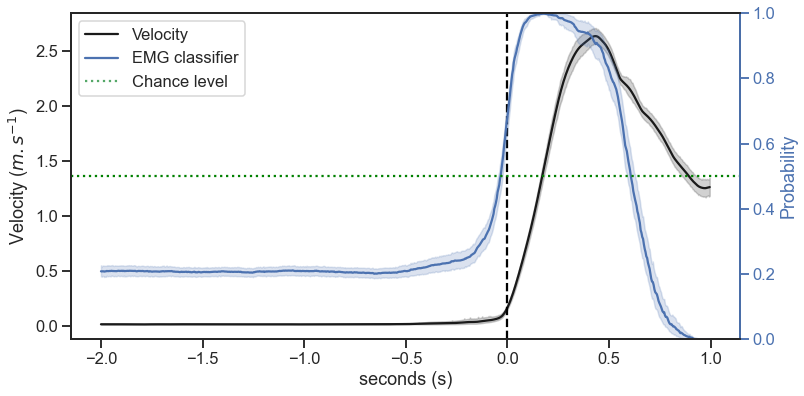

In [387]:
EMG_1 = ProcessEMG(11)

EEG Accuracy is 0.6683794466403162
EEG Standard deviation is 0.08431488775319136


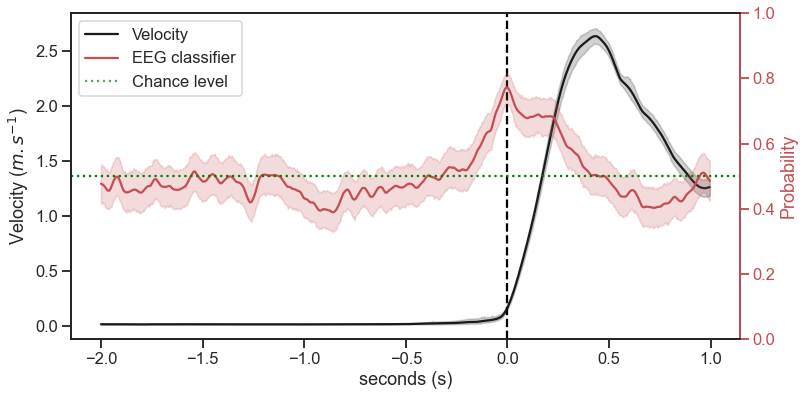

In [388]:
EEG_1 = ProcessEEG(11)

EEG-EMG Accuracy is 0.7866666666666666
EEG-EMG Standard deviation is 0.045215533220835144


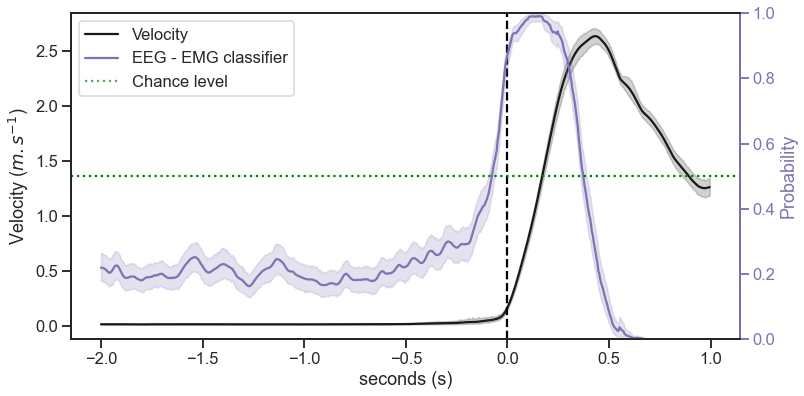

In [389]:
EEG_EMG_1 = ProcessEEG_EMG(11)

EMG Accuracy is 0.711111111111111
EMG Standard deviation is 0.06596856715021066


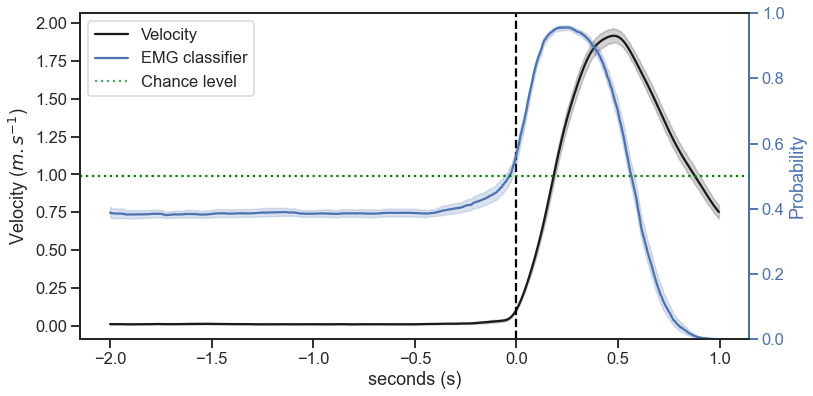

In [396]:
EMG_3 = ProcessEMG(3)

EEG Accuracy is 0.6367424242424242
EEG Standard deviation is 0.06781149430834406


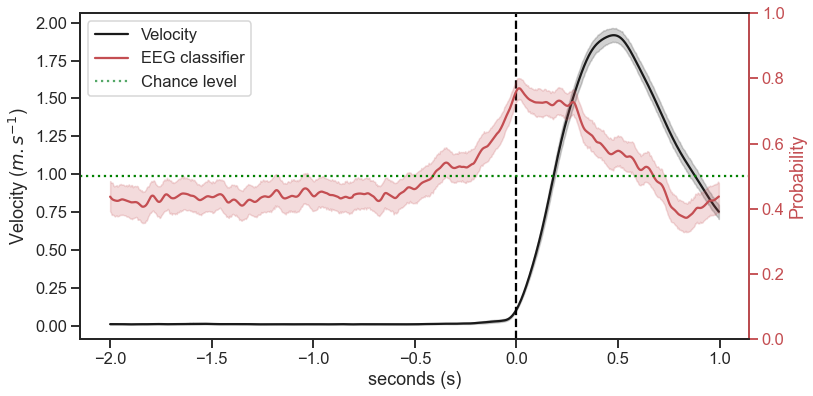

In [397]:
EEG_3 = ProcessEEG(3)

EEG-EMG Accuracy is 0.6888888888888889
EEG-EMG Standard deviation is 0.07934920476158722


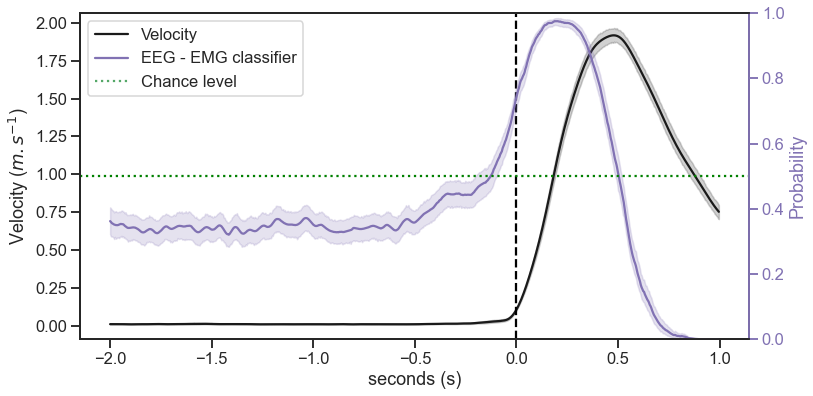

In [398]:
EEG_EMG_3 = ProcessEEG_EMG(3)

EMG Accuracy is 0.6616666666666666
EMG Standard deviation is 0.06000236200944109


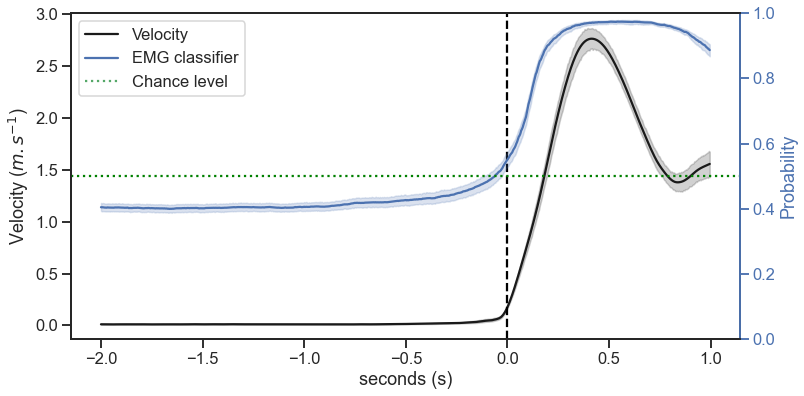

In [400]:
EMG_4 = ProcessEMG(4)

EEG Accuracy is 0.6632275132275133
EEG Standard deviation is 0.04645550854867905


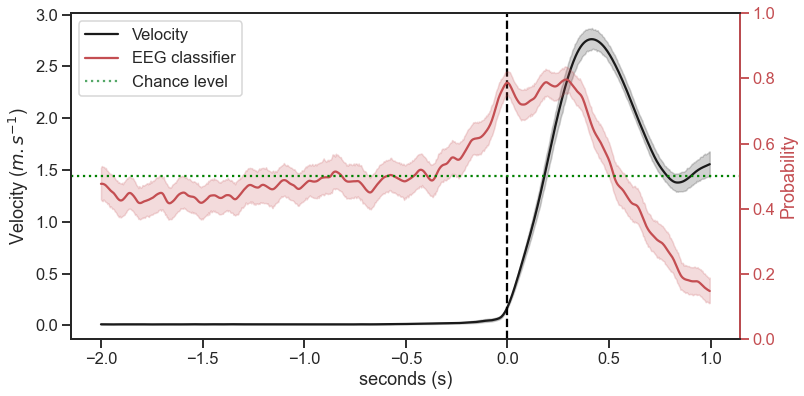

In [401]:
EEG_4 = ProcessEEG(4)

EEG-EMG Accuracy is 0.7036507936507936
EEG-EMG Standard deviation is 0.0630692269435039


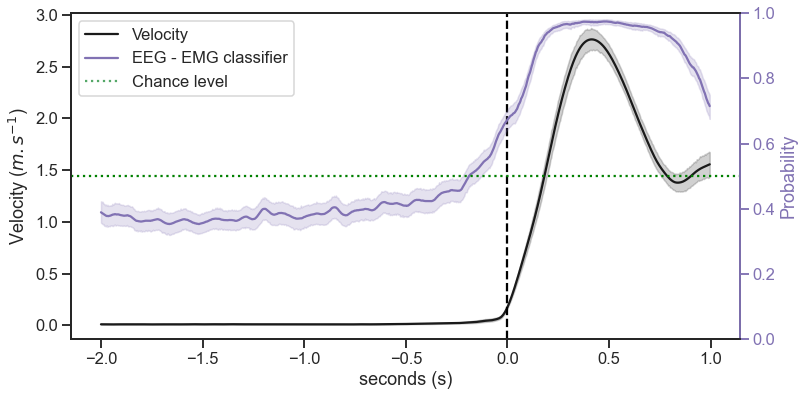

In [402]:
EEG_EMG_4 = ProcessEEG_EMG(4)

EMG Accuracy is 0.8173295454545455
EMG Standard deviation is 0.08357129634699667


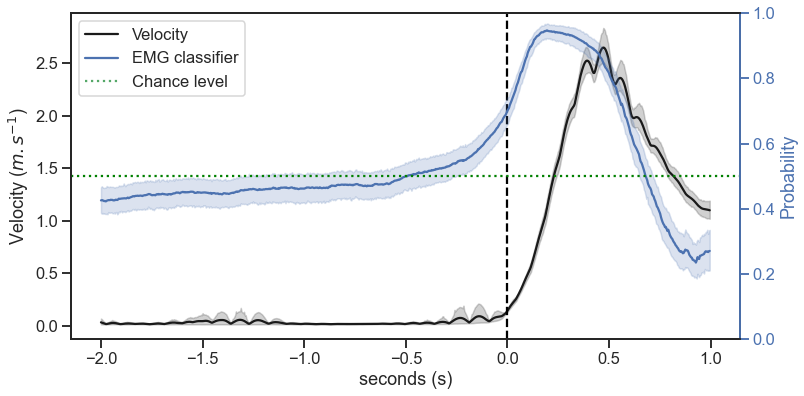

In [404]:
EMG_5 = ProcessEMG(5)

EEG Accuracy is 0.680952380952381
EEG Standard deviation is 0.040824829046386284


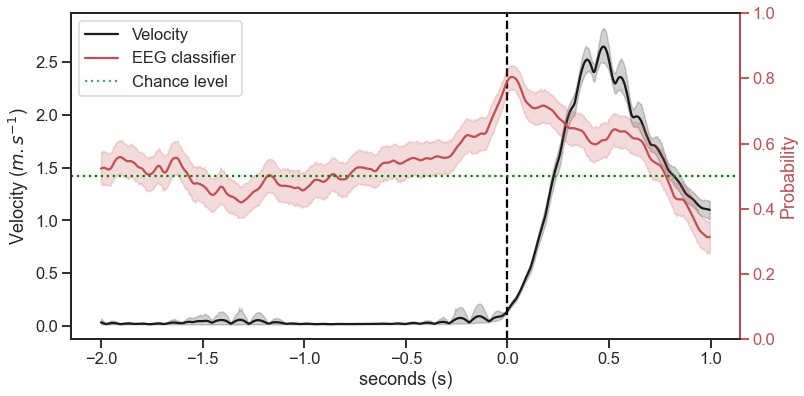

In [405]:
EEG_5 = ProcessEEG(5)

EEG-EMG Accuracy is 0.7829545454545455
EEG-EMG Standard deviation is 0.0789443376570957


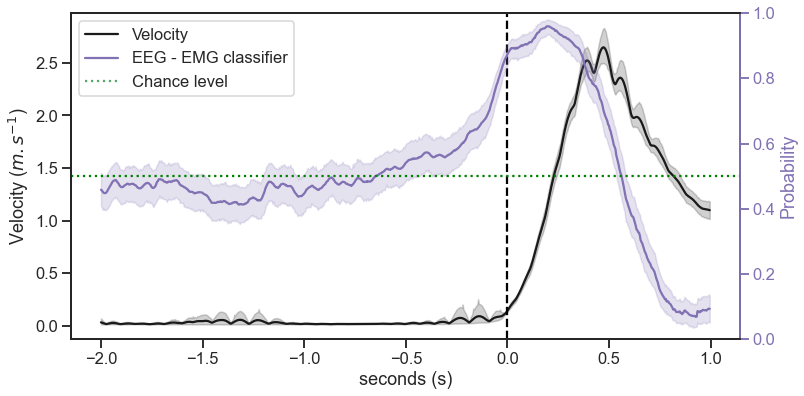

In [406]:
EEG_EMG_5 = ProcessEEG_EMG(5)

EMG Accuracy is 0.8600713012477719
EMG Standard deviation is 0.029960314285154385


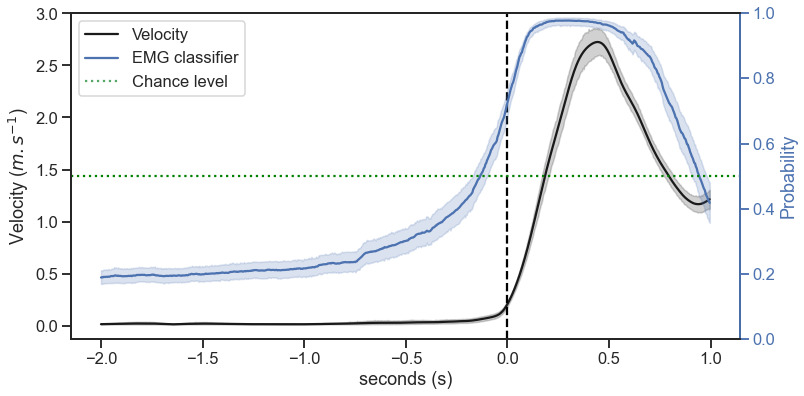

In [408]:
EMG_6 = ProcessEMG(6)

EEG Accuracy is 0.6227832512315272
EEG Standard deviation is 0.05558827373690161


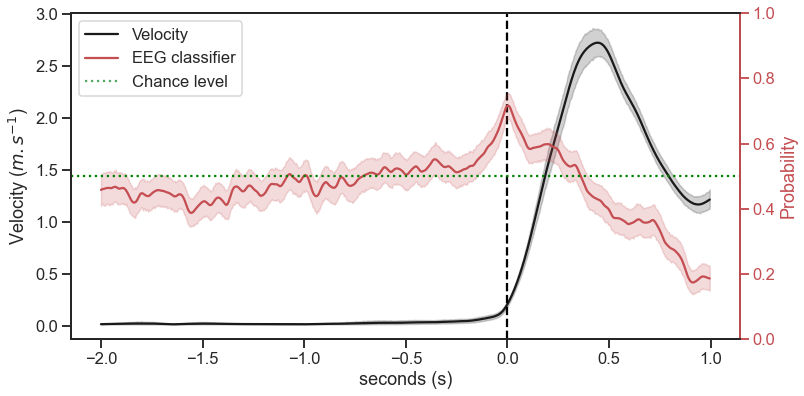

In [409]:
EEG_6 = ProcessEEG(6)

EEG-EMG Accuracy is 0.8508021390374332
EEG-EMG Standard deviation is 0.0561103899742821


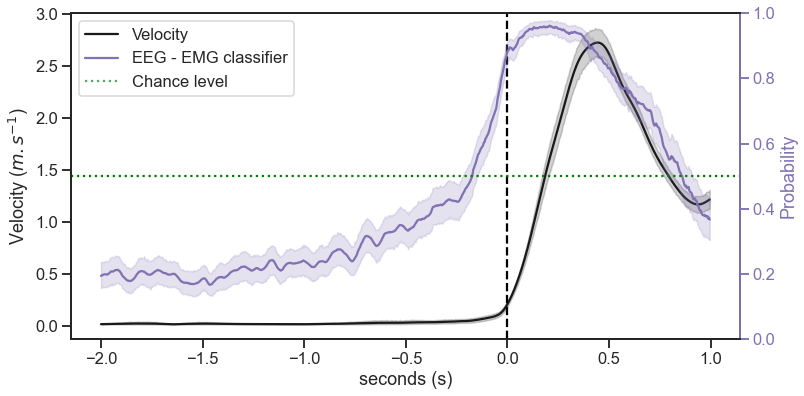

In [410]:
EEG_EMG_6 = ProcessEEG_EMG(6)

EMG Accuracy is 0.6333333333333333
EMG Standard deviation is 0.06549903401417552


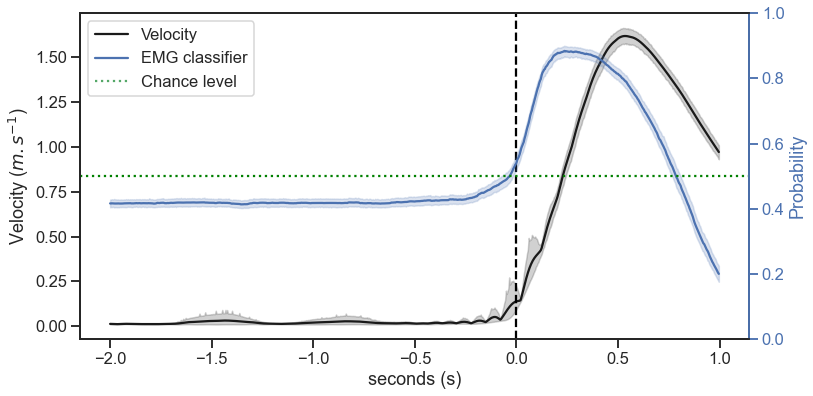

In [412]:
EMG_7 = ProcessEMG(7)

EEG Accuracy is 0.7195238095238095
EEG Standard deviation is 0.046761053451878684


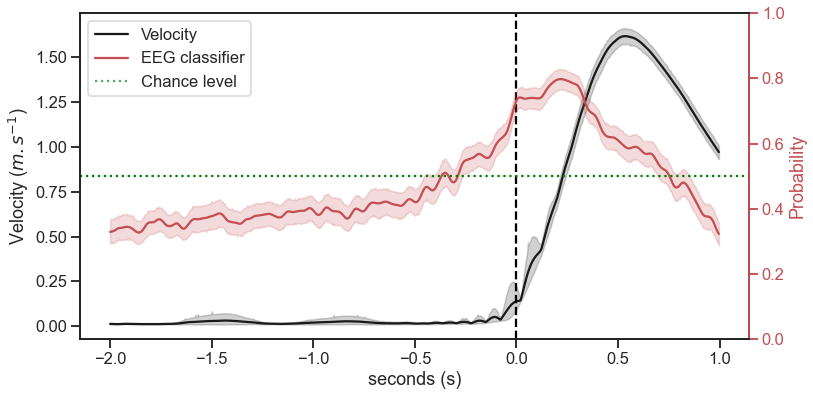

In [413]:
EEG_7 = ProcessEEG(7)

EEG-EMG Accuracy is 0.7166666666666667
EEG-EMG Standard deviation is 0.07222222222222224


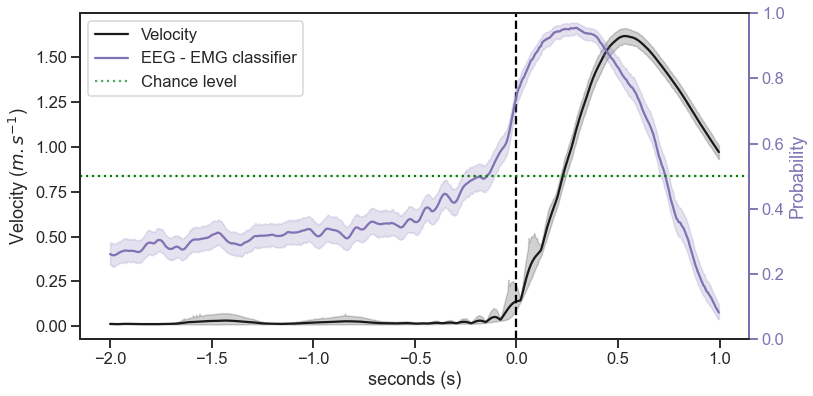

In [414]:
EEG_EMG_7 = ProcessEEG_EMG(7)

EMG Accuracy is 0.7108403361344537
EMG Standard deviation is 0.04720333453611404


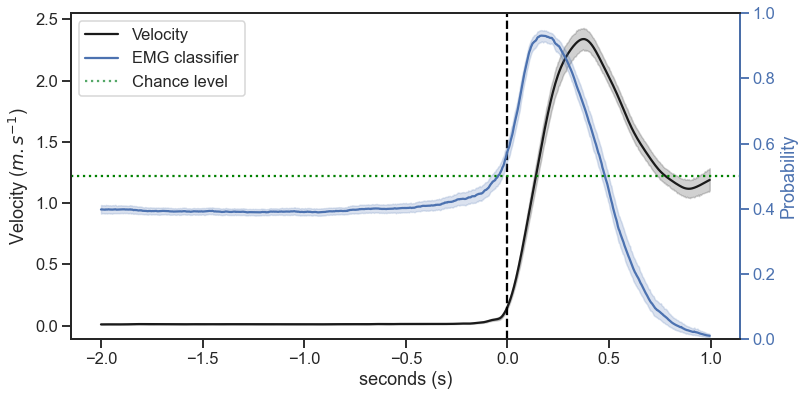

In [416]:
EMG_15 = ProcessEMG(15)

EEG Accuracy is 0.580919540229885
EEG Standard deviation is 0.0787204448814319


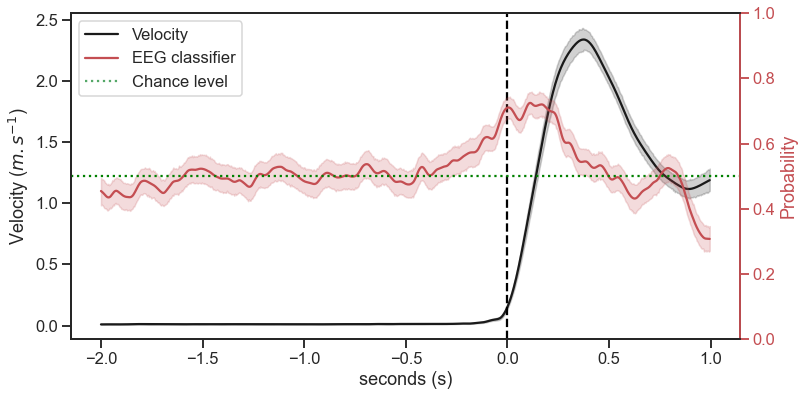

In [417]:
EEG_15 = ProcessEEG(15)

EEG-EMG Accuracy is 0.6848739495798319
EEG-EMG Standard deviation is 0.0995583780030851


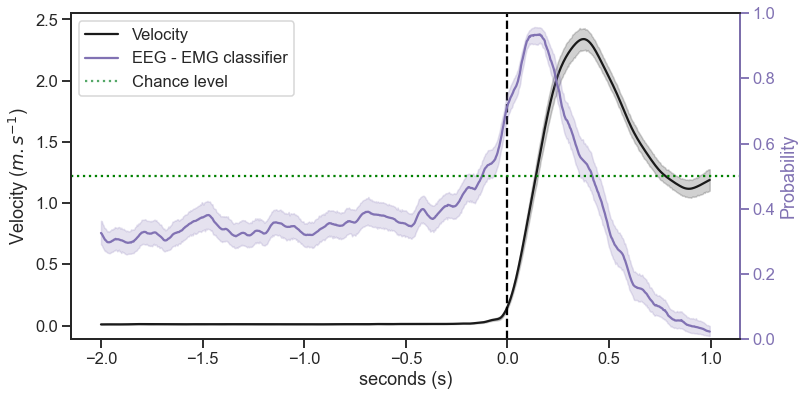

In [418]:
EEG_EMG_15 = ProcessEEG_EMG(15)

EMG Accuracy is 0.6204201680672268
EMG Standard deviation is 0.08578021027171882


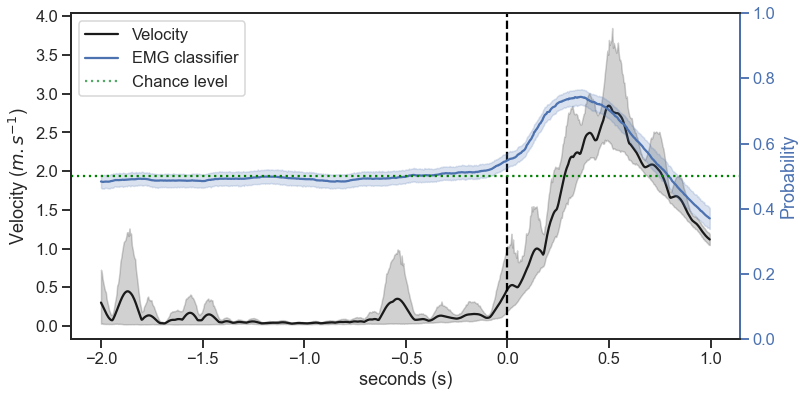

In [420]:
EMG_16 = ProcessEMG(16)

EEG Accuracy is 0.6979064039408868
EEG Standard deviation is 0.08583143076417385


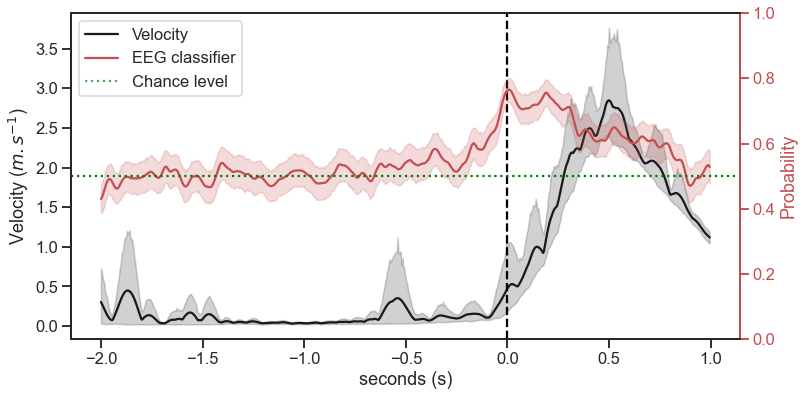

In [421]:
EEG_16 = ProcessEEG(16)

EEG-EMG Accuracy is 0.6958823529411765
EEG-EMG Standard deviation is 0.09035583134883322


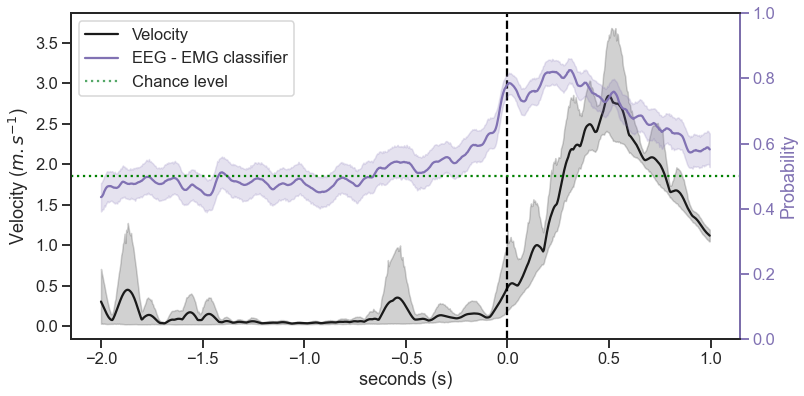

In [422]:
EEG_EMG_16 = ProcessEEG_EMG(16)

<font size="7" color='red'>    <b>Everything on the same plot</b>

In [ ]:
EMG = np.concatenate([EMG_1, EMG_3, EMG_4, EMG_5, EMG_6, EMG_7, EMG_15, EMG_16], axis=0)
EMG = pd.DataFrame(EMG, columns=['Time', 'Velocity', 'Probability', 'ID'])

EEG = np.concatenate([EEG_1, EEG_3, EEG_4, EEG_5, EEG_6, EEG_7, EEG_15, EEG_16], axis=0)
EEG = pd.DataFrame(EEG, columns=['Time', 'Velocity', 'Probability', 'ID'])

EEG_EMG = np.concatenate([EEG_EMG_1, EEG_EMG_3, EEG_EMG_4, EEG_EMG_5, EEG_EMG_6, EEG_EMG_7, EEG_EMG_15, EEG_EMG_16], axis=0)
EEG_EMG = pd.DataFrame(EEG_EMG, columns=['Time', 'Velocity', 'Probability', 'ID'])

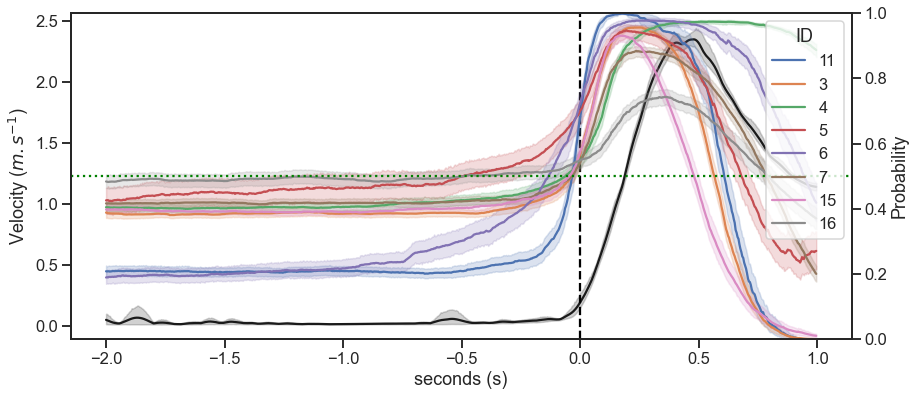

In [6]:
figure(figsize=(14, 6))

sns.set_theme(context='talk', style='ticks')
ep_move = sns.lineplot(data=EMG, x='Time', y='Velocity', color='k')

ep_move.set(xlabel='seconds (s)', ylabel="Velocity ($m.s^{-1}$)")

plt.axvline(0, color='black', label = 'onset', linestyle ='--')

ax2 = plt.twinx()
ax2.set_ylabel('Probability')

ep_prob = sns.lineplot(data=EMG, x='Time', y='Probability', hue='ID', ax=ax2)
plt.ylim((0,1))
plt.axhline(0.5, color='green', label = 'onset', linestyle ='dotted')

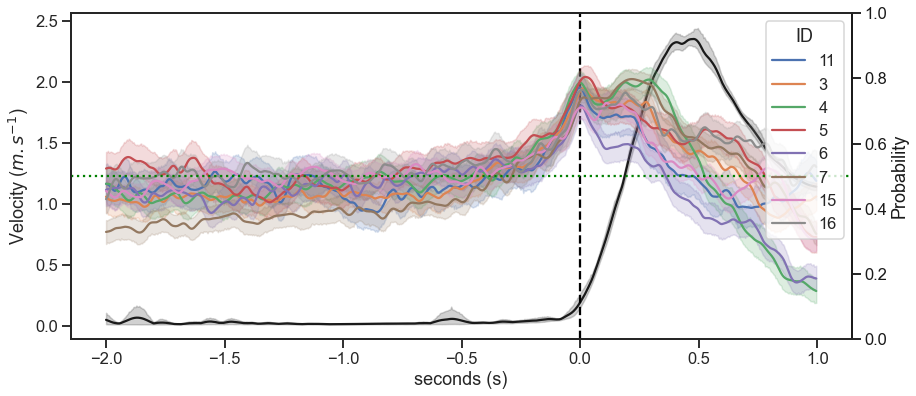

In [8]:
figure(figsize=(14, 6))

sns.set_theme(context='talk', style='ticks')
ep_move = sns.lineplot(data=EEG, x='Time', y='Velocity', color='k')

ep_move.set(xlabel='seconds (s)', ylabel="Velocity ($m.s^{-1}$)")

plt.axvline(0, color='black', label = 'onset', linestyle ='--')

ax2 = plt.twinx()
ax2.set_ylabel('Probability', color='k')
ax2.spines['right'].set_color('k')
ax2.tick_params(axis='y', colors='k')
ep_prob = sns.lineplot(data=EEG, x='Time', y='Probability', hue='ID', ax=ax2)
plt.ylim((0,1))
plt.axhline(0.5, color='green', label = 'onset', linestyle ='dotted')

#ep_prob.legend(loc='upper left', handles=[Line2D([], [], marker='_', color="k", label='Velocity'), 
#                                          Line2D([], [], marker='_', color="b", label='EMG classifier'),
#                                          Line2D([], [], linestyle ='dotted', color="g", label='Chance level')])

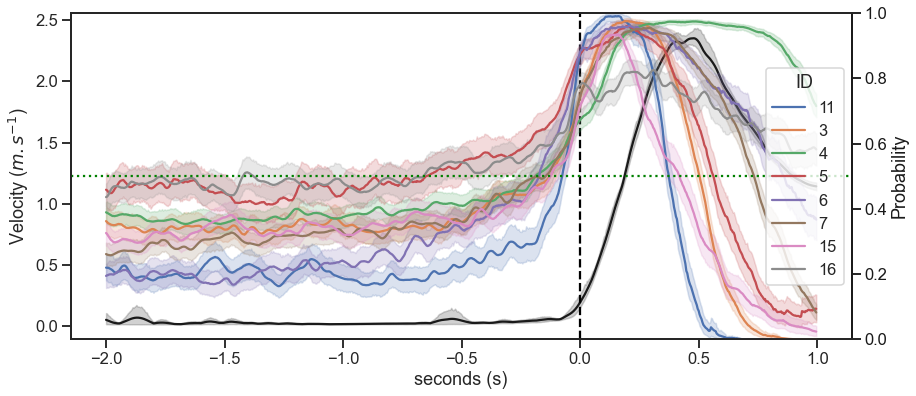

In [10]:
figure(figsize=(14, 6))

sns.set_theme(context='talk', style='ticks')
ep_move = sns.lineplot(data=EEG_EMG, x='Time', y='Velocity', color='k')

ep_move.set(xlabel='seconds (s)', ylabel="Velocity ($m.s^{-1}$)")

plt.axvline(0, color='black', label = 'onset', linestyle ='--')

ax2 = plt.twinx()
ax2.set_ylabel('Probability', color='k')
ax2.spines['right'].set_color('k')
ax2.tick_params(axis='y', colors='k')
ep_prob = sns.lineplot(data=EEG_EMG, x='Time', y='Probability', hue='ID', ax=ax2)
plt.ylim((0,1))
plt.axhline(0.5, color='green', label = 'onset', linestyle ='dotted')

#ep_prob.legend(loc='upper left', handles=[Line2D([], [], marker='_', color="k", label='Velocity'), 
#                                          Line2D([], [], marker='_', color="b", label='EMG classifier'),
#                                          Line2D([], [], linestyle ='dotted', color="g", label='Chance level')])

In [8]:
A_EMG = EMG.groupby(['ID', 'Time']).mean()

A_EEG = EEG.groupby(['ID', 'Time']).mean()

A_EEG_EMG = EEG_EMG.groupby(['ID', 'Time']).mean()

-0.03232841980103573
-0.07889687132830357


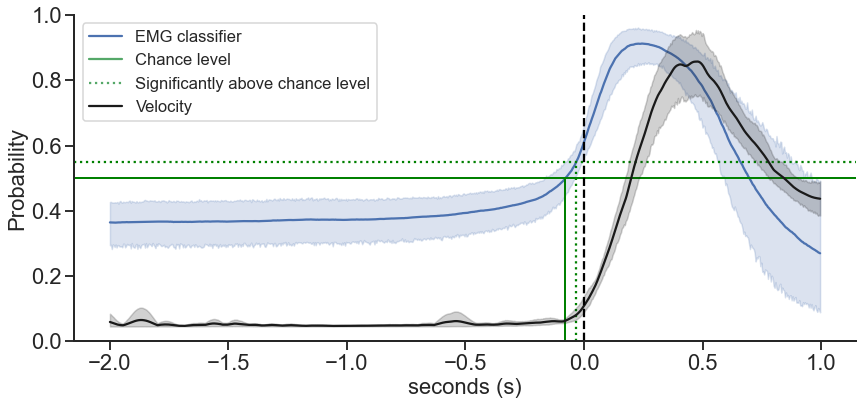

In [9]:
figure(figsize=(14, 6))

sns.set_theme(context='talk', style='ticks')

ep_prob = sns.lineplot(data=A_EMG, x='Time', y='Probability')
ep_prob.set_ylim((0, 1))
ep_prob.set_ylabel('Probability', fontsize=22)
ep_prob.set_xlabel('Time', fontsize=22)
ep_prob.tick_params(labelsize=22)

plt.axhline(y=0.55, color='green', label = 'onset', linestyle ='dotted')
plt.axhline(y=0.5, color='green', label = 'onset', linewidth = 2)
plt.axvline(x=np.interp(0.55, A_EMG.groupby(['Time']).mean()['Probability'].values[0:500], np.arange(-2, 0, 0.004))
                      ,ymin=0, ymax=0.55, color='green', label = 'onset', linestyle ='dotted')
plt.axvline(x=np.interp(0.50, A_EMG.groupby(['Time']).mean()['Probability'].values[0:500], np.arange(-2, 0, 0.004))
                      ,ymin=0, ymax=0.50, color='green', label = 'onset', linewidth = 2)

ax2 = plt.twinx()

ep_move = sns.lineplot(data=A_EMG, x='Time', y='Velocity', color='k', legend=False, ax=ax2)

ep_prob.set(xlabel='seconds (s)', ylabel="Probability")
plt.ylabel('', axes=ax2)
ep_move.set_yticks([])
ep_move.set(yticklabels=[])
sns.despine(right=True)

plt.axvline(0, color='black', label = 'onset', linestyle ='--')

ep_prob.legend(loc='upper left', handles=[ 
                                         Line2D([], [], marker='_', color="b", label='EMG classifier'),
                                        Line2D([], [], marker='_', color="g", label='Chance level'),
                                        Line2D([], [], linestyle ='dotted', color="g", label='Significantly above chance level'),
                                        Line2D([], [], marker='_', color="k", label='Velocity')])

print(np.interp(0.55, A_EMG.groupby(['Time']).mean()['Probability'].values[0:500], np.arange(-2, 0, 0.004)))
print(np.interp(0.50, A_EMG.groupby(['Time']).mean()['Probability'].values[0:500], np.arange(-2, 0, 0.004)))

plt.savefig("Prob_EMG.svg")

-0.22041146631097774
-0.46554820941670666


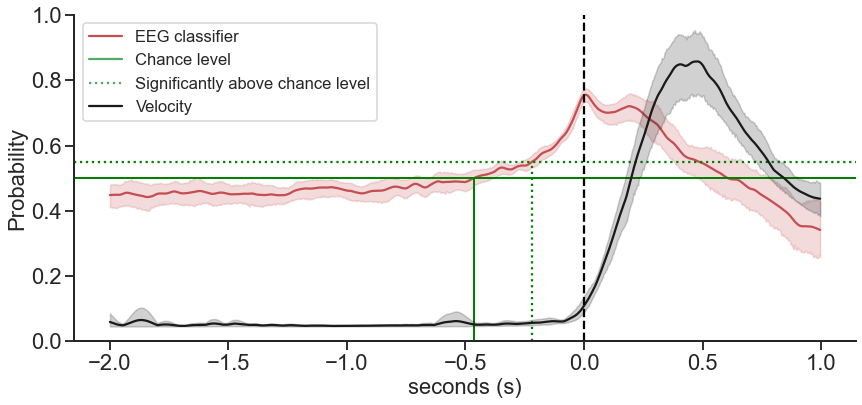

In [11]:
figure(figsize=(14, 6))

sns.set_theme(context='talk', style='ticks')

ep_prob = sns.lineplot(data=A_EEG, x='Time', y='Probability', color='r')
ep_prob.set_ylim((0, 1))
ep_prob.set_ylabel('Probability', fontsize=22)
ep_prob.set_xlabel('Time', fontsize=22)
ep_prob.tick_params(labelsize=22)

plt.axhline(y=0.55, color='green', label = 'onset', linestyle ='dotted')
plt.axhline(y=0.5, color='green', label = 'onset', linewidth = 2)
plt.axvline(x=np.interp(0.55, A_EEG.groupby(['Time']).mean()['Probability'].values[0:500], np.arange(-2, 0, 0.004))
                      ,ymin=0, ymax=0.55, color='green', label = 'onset', linestyle ='dotted')
plt.axvline(x=np.interp(0.50, A_EEG.groupby(['Time']).mean()['Probability'].values[0:500], np.arange(-2, 0, 0.004))
                      ,ymin=0, ymax=0.50, color='green', label = 'onset', linewidth = 2)

ax2 = plt.twinx()

ep_move = sns.lineplot(data=A_EEG, x='Time', y='Velocity', color='k', legend=False, ax=ax2)

ep_prob.set(xlabel='seconds (s)', ylabel="Probability")
plt.ylabel('', axes=ax2)
ep_move.set_yticks([])
ep_move.set(yticklabels=[])
sns.despine(right=True)

plt.axvline(0, color='black', label = 'onset', linestyle ='--')

ep_prob.legend(loc='upper left', handles=[
                                         Line2D([], [], marker='_', color="r", label='EEG classifier'),
                                        Line2D([], [], marker='_', color="g", label='Chance level'),
                                        Line2D([], [], linestyle ='dotted', color="g", label='Significantly above chance level'),
                                        Line2D([], [], marker='_', color="k", label='Velocity')])

print(np.interp(0.55, A_EEG.groupby(['Time']).mean()['Probability'].values[0:500], np.arange(-2, 0, 0.004)))
print(np.interp(0.50, A_EEG.groupby(['Time']).mean()['Probability'].values[0:500], np.arange(-2, 0, 0.004)))

plt.savefig("Prob_EEG.svg")

-0.11468774508185628
-0.17249920232436916


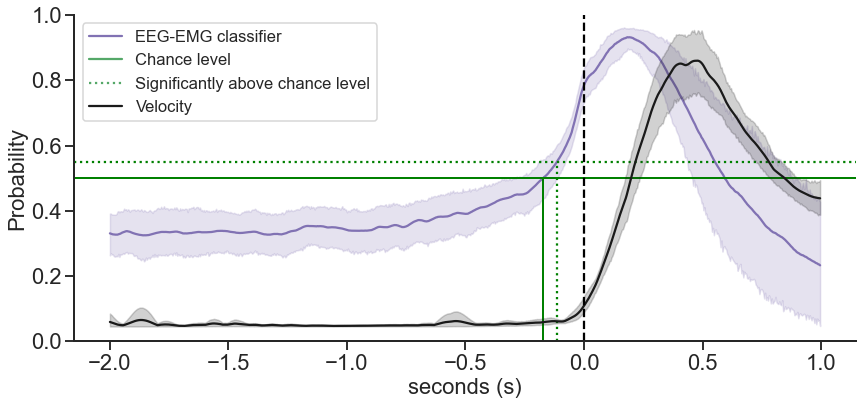

In [14]:
figure(figsize=(14, 6))

sns.set_theme(context='talk', style='ticks')

ep_prob = sns.lineplot(data=A_EEG_EMG, x='Time', y='Probability', color='m')
ep_prob.set_ylim((0, 1))
ep_prob.set_ylabel('Probability', fontsize=22)
ep_prob.set_xlabel('Time', fontsize=22)
ep_prob.tick_params(labelsize=22)

plt.axhline(y=0.55, color='green', label = 'onset', linestyle ='dotted')
plt.axhline(y=0.5, color='green', label = 'onset', linewidth = 2)
plt.axvline(x=np.interp(0.55, A_EEG_EMG.groupby(['Time']).mean()['Probability'].values[0:500], np.arange(-2, 0, 0.004))
                      ,ymin=0, ymax=0.55, color='green', label = 'onset', linestyle ='dotted')
plt.axvline(x=np.interp(0.50, A_EEG_EMG.groupby(['Time']).mean()['Probability'].values[0:500], np.arange(-2, 0, 0.004))
                      ,ymin=0, ymax=0.50, color='green', label = 'onset', linewidth = 2)

ax2 = plt.twinx()

ep_move = sns.lineplot(data=A_EEG_EMG, x='Time', y='Velocity', color='k', legend=False, ax=ax2)

ep_prob.set(xlabel='seconds (s)', ylabel="Probability")
plt.ylabel('', axes=ax2)
ep_move.set_yticks([])
ep_move.set(yticklabels=[])
sns.despine(right=True)

plt.axvline(0, color='black', label = 'onset', linestyle ='--')

ep_prob.legend(loc='upper left', handles=[ 
                                         Line2D([], [], marker='_', color="m", label='EEG-EMG classifier'),
                                        Line2D([], [], marker='_', color="g", label='Chance level'),
                                        Line2D([], [], linestyle ='dotted', color="g", label='Significantly above chance level'),
                                        Line2D([], [], marker='_', color="k", label='Velocity')])

print(np.interp(0.55, A_EEG_EMG.groupby(['Time']).mean()['Probability'].values[0:500], np.arange(-2, 0, 0.004)))
print(np.interp(0.50, A_EEG_EMG.groupby(['Time']).mean()['Probability'].values[0:500], np.arange(-2, 0, 0.004)))

plt.savefig("Prob_EEG_EMG.svg")

# II. Annex investigations: accuracy over time, feature weight

Another way to estimate the classification behaviour over time is to calulate and plot the accurcy on different time periods.
To do so, we use the data above. Instead of training the classifiers on 250 samples (1s) of data, we train them on 50 samples (0.2s) 5 times. That way we get the average accuracy on 5 times periods for each modality.

In [115]:
def accuracy_time(ID):
    
    data = load(ID)
    area = areas(data)
    
    idle_emg_feat = []
    intent_emg_feat = []
    EMG = []
    idle_eeg_feat = []
    intent_eeg_feat =[]
    idle_eeg_feat_cor = []
    intent_eeg_feat_cor =[]
    EEG = []
    idle_eeg_emg_feat = []
    intent_eeg_emg_feat = []
    EEG_EMG = []
    
    
    for i in range(5):
        idle_emg_feat.append(emg_feature_extraction(area['idle_emg'][:, 50*i:50+50*i, :]))
        
        intent_emg_feat.append(emg_feature_extraction(area['intent_emg'][:, 50*i:50+50*i, :]))
        
        EMG.append(classification(ID, np.asarray(idle_emg_feat)[i, :, :], np.asarray(intent_emg_feat)[i, :, :]))
        
        
        idle_eeg_feat.append(eeg_feature_extraction(area['idle_eeg'][:, 50*i:50+50*i, :]))
        
        intent_eeg_feat.append(eeg_feature_extraction(area['intent_eeg'][:, 50*i:50+50*i, :]))
        
        idle_eeg_feat_cor.append(baseline_correction(area['idle_eeg'][:, 50*i:50+50*i, :], idle_eeg_feat[i]))
        
        intent_eeg_feat_cor.append(baseline_correction(area['intent_eeg'][:, 50*i:50+50*i, :], intent_eeg_feat[i]))
        
        EEG.append(classification(ID, np.asarray(idle_eeg_feat_cor)[i, :, :], np.asarray(intent_eeg_feat_cor)[i, :, :]))
        
        
        idle_eeg_emg_feat.append(np.concatenate((np.asarray(idle_emg_feat)[i, :, :], 
                                                 np.asarray(idle_eeg_feat_cor)[i, :, :]), axis=1))
        
        intent_eeg_emg_feat.append(np.concatenate((np.asarray(intent_emg_feat)[i, :, :], 
                                                   np.asarray(intent_eeg_feat_cor)[i, :, :]), axis=1))
        
        EEG_EMG.append(classification(ID, np.asarray(idle_eeg_emg_feat)[i, :, :], np.asarray(intent_eeg_emg_feat)[i, :, :]))
    
    return EMG, EEG, EEG_EMG

In [116]:
def all_accuracies(IDs):
    
    alla = []
    
    for ID in IDs:
        alla.append(accuracy_time(ID))
    
    accs = []
    ID = []
    mod = ['EMG', 'EEG', 'EEG-EMG']
    moda = []
    tim = ['-900', '-700', '-500', '-300', '-100']
    time = []

    for k in range(len(IDs)):
    
        ID.append([f'{IDs[k]}'] * len(alla[0]) * len(alla[0][0]))
    
        for j in range(len(alla[0])):
        
            moda.append([mod[j]]* len(alla[0][0]))
        
            for i in range(len(alla[0][0])):
        
                accs.append(alla[k][j][i]['Score'])
                time.append(tim[i])
            
    ID = list(np.concatenate(ID).flat)
    moda = list(np.concatenate(moda).flat)

    data = pd.DataFrame(list(zip(accs, time, moda, ID)), columns=['Accuracy', 'Training interval', 'Modality', 'ID'])
    
    figure(figsize=(10,6))
    sns.set_context('talk', rc={"font.size":15,"axes.titlesize":15,"axes.labelsize":15})
    sns.set_color_codes('pastel')
    f= sns.barplot(x = 'Training interval', y='Accuracy', hue = 'Modality', data = data, palette=['tab:blue', 'tab:red', 'tab:purple'])
    f.set(xlabel='Training interval (ms)')
    plt.ylim((0.4,0.9))
    f.legend(loc='upper left')
    sns.despine()
    
    return data

EMG Accuracy is 0.53
EMG Standard deviation is 0.09
EEG Accuracy is 0.5766666666666667
EEG Standard deviation is 0.07895146188218005
EEG-EMG Accuracy is 0.5633333333333332
EEG-EMG Standard deviation is 0.06741249472052227
EMG Accuracy is 0.45
EMG Standard deviation is 0.08465616732800196
EEG Accuracy is 0.5766666666666667
EEG Standard deviation is 0.09666666666666666
EEG-EMG Accuracy is 0.5766666666666665
EEG-EMG Standard deviation is 0.10959521481849065
EMG Accuracy is 0.5499999999999999
EMG Standard deviation is 0.0957427107756338
EEG Accuracy is 0.51
EEG Standard deviation is 0.057831171909658224
EEG-EMG Accuracy is 0.48
EEG-EMG Standard deviation is 0.092135166407235
EMG Accuracy is 0.5199999999999999
EMG Standard deviation is 0.11661903789690599
EEG Accuracy is 0.5633333333333332
EEG Standard deviation is 0.07666666666666665
EEG-EMG Accuracy is 0.5399999999999998
EEG-EMG Standard deviation is 0.07859884081701062
EMG Accuracy is 0.85
EMG Standard deviation is 0.07187952884282607
EE

EEG-EMG Accuracy is 0.5171428571428571
EEG-EMG Standard deviation is 0.0818180191861225
EMG Accuracy is 0.7716806722689075
EMG Standard deviation is 0.08139821307108575
EEG Accuracy is 0.5760504201680672
EEG Standard deviation is 0.10095739004600297
EEG-EMG Accuracy is 0.734201680672269
EEG-EMG Standard deviation is 0.06075467529231809
EMG Accuracy is 0.6090756302521008
EMG Standard deviation is 0.06605469654940002
EEG Accuracy is 0.5147899159663865
EEG Standard deviation is 0.0940277181411374
EEG-EMG Accuracy is 0.6065546218487394
EEG-EMG Standard deviation is 0.06576004768243056
EMG Accuracy is 0.5601680672268907
EMG Standard deviation is 0.08367672112744336
EEG Accuracy is 0.5025210084033613
EEG Standard deviation is 0.07903449577105673
EEG-EMG Accuracy is 0.5716806722689075
EEG-EMG Standard deviation is 0.07578513552452945
EMG Accuracy is 0.49756302521008405
EMG Standard deviation is 0.08102378772289594
EEG Accuracy is 0.5284033613445378
EEG Standard deviation is 0.0340907291253999

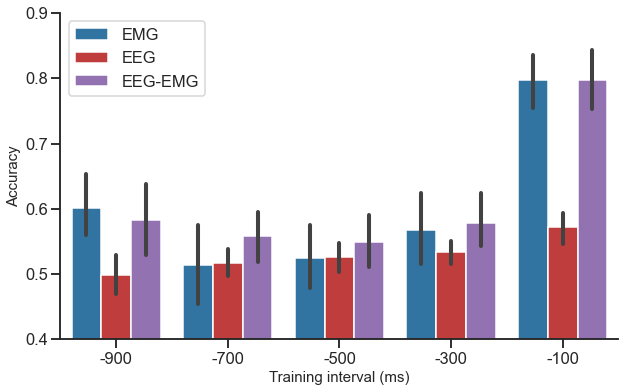

In [117]:
z = all_accuracies([11, 3, 4, 5, 6, 7, 15, 16])

# III. Feature weight

In [27]:
def EMG_features_weighting(ID):
    
    a = load(str(ID))
    b = areas(a)
    
    idle         = b['idle_emg']
    intent       = b['intent_emg']
    
    idle_feat    = emg_feature_extraction(idle)
    intent_feat  = emg_feature_extraction(intent)
    
    Ridle_feat   = idle_feat.reshape(idle_feat.shape[0]*idle_feat.shape[1])
    Rintent_feat = intent_feat.reshape(intent_feat.shape[0]*intent_feat.shape[1])
    
    nFeat = ['RMS', 'min', 'max', 'MAV', 'VAR', 'Waveform', 'ZC', 'SSC']*(len(Ridle_feat)//8)*2
    Values = np.concatenate((Ridle_feat, Rintent_feat))
    Class = ['Idle'] * (len(Ridle_feat)) + ['Pre-move'] * (len(Rintent_feat))
    ID = [str(ID)]*len(Ridle_feat)*2
    
    EMG_DF = pd.DataFrame({'Features': nFeat, 'Values': Values, 'Class': Class, 'ID': ID})
    
    return EMG_DF

In [28]:
EMGfeat_11 = EMG_features_weighting(11)
EMGfeat_3  = EMG_features_weighting(3)
EMGfeat_4  = EMG_features_weighting(4)
EMGfeat_5  = EMG_features_weighting(5)
EMGfeat_6  = EMG_features_weighting(6)
EMGfeat_7  = EMG_features_weighting(7)
EMGfeat_15 = EMG_features_weighting(15)
EMGfeat_16 = EMG_features_weighting(16)
EMGfeat = np.concatenate([EMGfeat_11, EMGfeat_3, EMGfeat_4, EMGfeat_5, EMGfeat_6, EMGfeat_7, EMGfeat_15, EMGfeat_16], axis=0)
EMGfeat = pd.DataFrame(EMGfeat, columns=['Feature', 'Values (a.u.)', 'Class', 'ID'])

In [29]:
feat_mean = EMGfeat.groupby(['Feature'])['Values (a.u.)'].mean()
feat_std = EMGfeat.groupby(['Feature'])['Values (a.u.)'].std()

for i in range(len(EMGfeat)//len(feat_mean)):    
    EMGfeat.loc[i*8, 'Values (a.u.)'] = (EMGfeat.loc[i*8, 'Values (a.u.)'] - feat_mean['RMS']) / feat_std['RMS']

for i in range(len(EMGfeat)//len(feat_mean)):    
    EMGfeat.loc[1+(i*8), 'Values (a.u.)'] = (EMGfeat.loc[1+(i*8), 'Values (a.u.)'] - feat_mean['min']) / feat_std['min']
    
for i in range(len(EMGfeat)//len(feat_mean)):    
    EMGfeat.loc[2+(i*8), 'Values (a.u.)'] = (EMGfeat.loc[2+(i*8), 'Values (a.u.)'] - feat_mean['max']) / feat_std['max']
    
for i in range(len(EMGfeat)//len(feat_mean)):    
    EMGfeat.loc[3+(i*8), 'Values (a.u.)'] = (EMGfeat.loc[3+(i*8), 'Values (a.u.)'] - feat_mean['MAV']) / feat_std['MAV']
    
for i in range(len(EMGfeat)//len(feat_mean)):    
    EMGfeat.loc[4+(i*8), 'Values (a.u.)'] = (EMGfeat.loc[4+(i*8), 'Values (a.u.)'] - feat_mean['VAR']) / feat_std['VAR']

for i in range(len(EMGfeat)//len(feat_mean)):    
    EMGfeat.loc[5+(i*8), 'Values (a.u.)'] = (EMGfeat.loc[5+(i*8), 'Values (a.u.)'] - feat_mean['Waveform']) / feat_std['Waveform']
    
for i in range(len(EMGfeat)//len(feat_mean)):    
    EMGfeat.loc[6+(i*8), 'Values (a.u.)'] = (EMGfeat.loc[6+(i*8), 'Values (a.u.)'] - feat_mean['ZC']) / feat_std['ZC']
    
for i in range(len(EMGfeat)//len(feat_mean)):    
    EMGfeat.loc[7+(i*8), 'Values (a.u.)'] = (EMGfeat.loc[7+(i*8), 'Values (a.u.)'] - feat_mean['SSC']) / feat_std['SSC']

In [30]:
mg = pd.DataFrame(EMGfeat.to_dict())

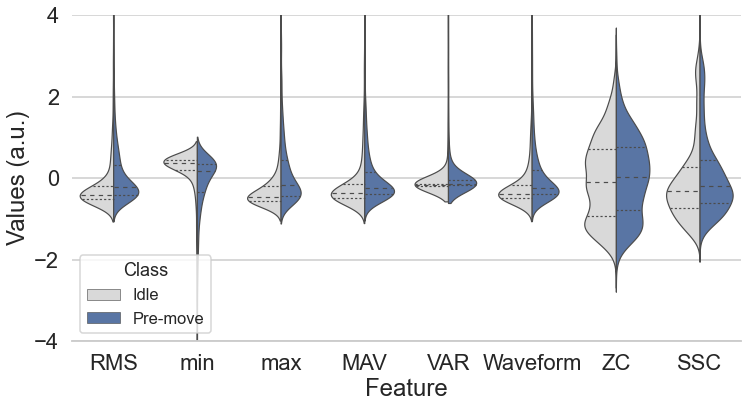

In [32]:
figure(figsize=(12, 6))
    
sns.set_theme(style="whitegrid")
sns.set_context("talk")

g= sns.violinplot(data=mg, x="Feature", y="Values (a.u.)", hue="Class", dodge=False, scale_hue=True, gridsize=1000,
               split=True, inner="quart", linewidth=1.2,
               palette={"Idle": ".85", "Pre-move": "b"})
g.set_ylim((-4, 4))
g.set_xlabel("Feature", fontsize=24)
g.set_ylabel("Values (a.u.)", fontsize=24)
g.tick_params(labelsize=22)


sns.despine(left=True)
sns.move_legend(g, "lower left")


In [65]:
def EEG_features_weighting(ID):
    
    a = load(str(ID))
    b = areas(a)
    
    idle         = b['idle_eeg']
    intent       = b['intent_eeg']
    
    idle_feat_n    = eeg_feature_extraction(idle)
    intent_feat_n  = eeg_feature_extraction(intent)
    
    idle_feat    = baseline_correction(b['idle_eeg'], idle_feat_n)
    intent_feat  = baseline_correction(b['intent_eeg'], intent_feat_n)
    
    Ridle_feat   = idle_feat.reshape(idle_feat.shape[0]*idle_feat.shape[1])
    Rintent_feat = intent_feat.reshape(intent_feat.shape[0]*intent_feat.shape[1])
    
    nFeat = ['0-25', '22-50', '50-75', '75-100', '100-125',
             '125-150', '150-175', '175-200', '200-225', '225-250']*(len(Ridle_feat)//10)*2
    Values = np.concatenate((Ridle_feat, Rintent_feat))
    Class = ['Idle'] * (len(Ridle_feat)) + ['Pre-move'] * (len(Rintent_feat))
    ID = [str(ID)]*len(Ridle_feat)*2
    
    EEG_DF = pd.DataFrame({'Features': nFeat, 'Values': Values, 'Class': Class, 'ID': ID})
    
    return EEG_DF

In [34]:
EEGfeat_11 = EEG_features_weighting(11)
EEGfeat_3  = EEG_features_weighting(3)
EEGfeat_4  = EEG_features_weighting(4)
EEGfeat_5  = EEG_features_weighting(5)
EEGfeat_6  = EEG_features_weighting(6)
EEGfeat_7  = EEG_features_weighting(7)
EEGfeat_15 = EEG_features_weighting(15)
EEGfeat_16 = EEG_features_weighting(16)
EEGfeat = np.concatenate([EEGfeat_11, EEGfeat_3, EEGfeat_4, EEGfeat_5, EEGfeat_6, EEGfeat_7, EEGfeat_15, EEGfeat_16], axis=0)
EEGfeat = pd.DataFrame(EEGfeat, columns=['Features (samples)', 'Values (\u03bcV)', 'Class', 'ID'])

temp = pd.DataFrame(EEGfeat.to_dict())

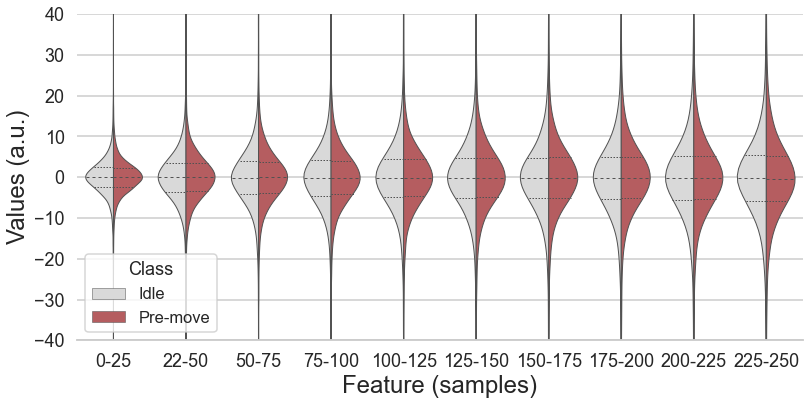

In [40]:
figure(figsize=(13, 6))
sns.set_theme(style="whitegrid")
sns.set_context("talk")

g2 = sns.violinplot(data=temp, x="Features (samples)", y="Values (\u03bcV)", hue="Class", dodge=False, cut=0, gridsize=1000,
               split=True, inner="quart", linewidth=1,
               palette={"Idle": ".85", "Pre-move": "r"})
g2.set_ylim((-40, 40))
g2.set_xlabel("Feature (samples)", fontsize=24)
g2.set_ylabel("Values (a.u.)", fontsize=24)
g2.tick_params(labelsize=18)

sns.despine(left=True)
sns.move_legend(g2, "lower left")